Follows the examples in https://gist.github.com/ljmartin/523fefaf2528ab84be3e1868136b5852#file-molecules_with_fresnel-ipynb to generate fancy renders of proteins for the ASAP pipeline. These will be rendered as a tiny image, so between proteins we will have to make sure coloring is diverse in order to make them distinguishable. 

In [36]:
import MDAnalysis as mda
from rdkit import Chem
from rdkit.Chem import AllChem

import fresnel

import numpy as np

#autocomplete wasn't working (or too slow) - this fixes it:
%config Completer.use_jedi = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import urllib # for downloading PDBs
import random # for random colors
import PIL # to save the rendered output to a png file with transparency


In [2]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from PIL import ImageColor


def view_colormap(cmap):
    """Plot a colormap with its grayscale equivalent"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    print(colors)
    
    fig, ax = plt.subplots(1, figsize=(6, 2),
                           subplot_kw=dict(xticks=[], yticks=[]))
    ax.imshow([colors], extent=[0, 10, 0, 1])
    return colors

[[0.89803922 0.42745098 0.37647059 1.        ]
 [0.93333333 0.6        0.26666667 1.        ]
 [0.44313725 0.43137255 0.50196078 1.        ]
 [0.91764706 0.87058824 0.80392157 1.        ]
 [0.80784314 0.78039216 0.2745098  1.        ]
 [0.75294118 0.26666667 0.24705882 1.        ]
 [0.45098039 0.30196078 0.3372549  1.        ]
 [0.36470588 0.37254902 0.48235294 1.        ]
 [0.9254902  0.71372549 0.25882353 1.        ]
 [0.54117647 0.58039216 0.25490196 1.        ]]


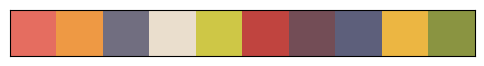

In [3]:
# First, we create a color map for gumballs.
colors = [
    '#e56d60',
    '#ee9944',
    '#716e80',
    '#eadecd',
    '#cec746',
    '#c0443f',
    '#734d56',
    '#5d5f7b',
    '#ecb642',
    '#8a9441',
]
cmap = LinearSegmentedColormap.from_list(name='gumball',
                                         colors=colors,
                                         N=len(colors))

color_rgbas = view_colormap(cmap)

In [4]:
# test the basic example.
smi = 'C1=CN=C2C(=C1)C=CN2' #7-azaindole
mol = Chem.MolFromSmiles(smi)
#optimize:
opt=True
if opt:
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, useExpTorsionAnglePrefs=True,useBasicKnowledge=True)
    AllChem.UFFOptimizeMolecule(mol)

positions = mol.GetConformer(0).GetPositions()
radii = np.array([Chem.GetPeriodicTable().GetRvdw(a.GetAtomicNum()) for a in mol.GetAtoms()])

In [96]:
pt = Chem.GetPeriodicTable()
atom_types = [pt.GetElementSymbol(a.GetAtomicNum()) for a in mol.GetAtoms()]

color_dict = {
    'C':1,
    'H':3,
    'N':2,
    'O':5,
    'S':8,
    'P':9,
    'F':4,
    'Cl':6,
    'Zn' : 7,
    'H' : 8,
    'Ca' : 7
}


color_rgbas = fresnel.color.linear(cmap(np.arange(cmap.N)))
color = np.array([color_rgbas[color_dict[i]] for i in atom_types])

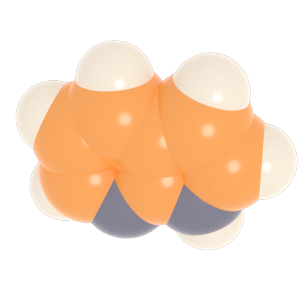

In [6]:
material = fresnel.material.Material(
    primitive_color_mix=1.0,
    roughness=0.2,
    specular=0.8,
)

# We create a fresnel scene and its geometry.
scene = fresnel.Scene()

geometry = fresnel.geometry.Sphere(
    scene,
    position=positions,
    radius=radii,
    color=color,
    material=material,
)



# Configure camera and lighting.
scene.camera = fresnel.camera.Perspective(position=(0, 0, 20),
                                          look_at=(0, 0, 0),
                                          up=(0, 1, 0),
                                          focal_length=0.5,
                                          f_stop=2)

scene.camera.focus_on = (0, 0, 0)
scene.lights = fresnel.light.lightbox()
scene.lights.append(
    fresnel.light.Light(direction=(0.3, -0.3, 1),
                        #color=(0.9, 0.9, 0.9),
                        theta=np.pi/15))

# Execute rendering.
out = fresnel.pathtrace(scene, w=300, h=300, samples=500, light_samples=28)
out

Ok - works as advertized. Now wrap the 'goodsell' representation in a function and iterate over targets.

In [93]:
#see https://www.cgl.ucsf.edu/chimerax/docs/user/radii.html
radius_lookup = {}
radius_lookup['C']=1.7
radius_lookup['H']=1.0
radius_lookup['N']=1.625
radius_lookup['O']=1.49
radius_lookup['S']=1.782
radius_lookup['P']=1.871
radius_lookup['F']=1.560
radius_lookup['Cl']=1.735
radius_lookup['Zn']=1.39
radius_lookup['Ca']=1.34

In [110]:
def createRender(pdbid, camera_position, radius_lookup, tgt_name):
    """
    Loads in a PDB file, creates a rendering using fresnel and saves the rendering in PNG to ../.
    
    pdbid : PDB code for protein of interest
    camera position (tuple of 3) : x/y/z coordinates of camera
    radius_lookup (dict) : dict that contains atom radii per element
    """
    print(pdbid)
    # load in the PDB.
    _ = urllib.request.urlretrieve(f'http://files.rcsb.org/download/{pdbid.lower()}.pdb', f'{pdbid.lower()}.pdb')
    
    u = mda.Universe(f'{pdbid.lower()}.pdb')
    prot = u.select_atoms("protein")
    lig = u.select_atoms("not protein and not resname HOH and not name MG")

    # define all atom colors and radii for the protein.
    protcolors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
         for i in range(10)] # generate random color scheme of n=10.
    prot_atom_types = [i.element for i in prot]
    prot_col_idx = [color_dict[i] for i in prot_atom_types]
    prot_colors = np.array([protcolors[i] for i in prot_col_idx])
    protcmap = LinearSegmentedColormap.from_list(name='lig',
                                             colors=prot_colors,
                                             N=len(prot_colors))
    cmap = plt.cm.get_cmap(protcmap)
    prot_color_rgbas = cmap(np.arange(cmap.N))
    
    prot_radii = [radius_lookup[i] for i in prot_atom_types]
    goodsell_dict = {
    'C':2,
    'N':3,
    'O':4,
    'P':5,
    'S':6,
    'H':7,
    'Ca':8
    } 
    gdsl_col_idx = [goodsell_dict[i] for i in prot_atom_types]
    gdsl_colors = np.array([prot_color_rgbas[i][:3] for i in gdsl_col_idx]) # not sure why the slice is needed but it works.

    prot_material = fresnel.material.Material(
    primitive_color_mix=1.0,
    roughness=1,
    specular=0,
    solid=0.9
    )
    
    # now also for the ligand, if present.
    lig_atom_types = [i.element for i in lig]
    ligcolors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(10)] # generate random color scheme of n=10.

    ligcmap = LinearSegmentedColormap.from_list(name='lig',
                                             colors=ligcolors,
                                             N=len(ligcolors))
    cmap = plt.cm.get_cmap(ligcmap)
    lig_color_rgbas = cmap(np.arange(cmap.N))

    lig_col_idx = [color_dict[i] for i in lig_atom_types]
    lig_colors = np.array([lig_color_rgbas[i] for i in lig_col_idx])
    lig_radii = [radius_lookup[i] for i in lig_atom_types]
    
    


    # We create a fresnel scene and its geometry.
    scene = fresnel.Scene()

    geometry = fresnel.geometry.Sphere(
        scene,
        position=prot.positions - prot.positions.mean(0),
        radius=prot_radii,
        color=gdsl_colors,
        material=prot_material,
        outline_width=0.175
    )


    ligmaterial = fresnel.material.Material(
        primitive_color_mix=1.0,
        roughness=0.2,
        specular=0.8,
        solid=0.9
    )

    if lig.positions.any():
        lig_geom = fresnel.geometry.Sphere(
            scene,
            position=lig.positions - prot.positions.mean(0),
            radius=lig_radii,
            color=lig_colors[:,:-1],
            material=ligmaterial,
             outline_width = 0.175,
        )
    else: # no ligand present.
        lig_geom = None

    # Configure camera and lighting.
    scene.camera = fresnel.camera.Perspective(position=camera_position,
                                              look_at=(0, 0, 0),
                                              up=(0, 1, 0),
                                              focal_length=0.5,
                                              f_stop=2)

    scene.camera.focus_on = (0, 0, 0)
    scene.lights = fresnel.light.lightbox()
    scene.lights.append(
        fresnel.light.Light(direction=(0.3, -0.3, 1),
                            color=(0.2, 0.2, 0.2),
                            theta=np.pi/15))

    # Execute rendering.
    out = fresnel.pathtrace(scene, w=600, h=600, samples=500, light_samples=24)
    
    image = PIL.Image.fromarray(out[:], mode='RGBA')
    image.save(f'../{tgt_name}.png')
    

In [116]:
targets_dict = { # need to define the PDB IDs (for download) and camera position (not ideal - depends on protein coords + size)
    "SARS-CoV-2 Mpro" : ["7TLL", (120, 0, -180)],
    "DENV-ns2b-ns3" : ["2FOM", (80, 0, -100)],
    "coronavirus-endoribonuclease" : ["7TQV", (120, 0, -250)],
    "enterovirus-2A-protease" : ["7DA6", (120, 0, -60)],
    "enterovirus-3C-protease" : ["8CNX", (60, 0, -160)],
    "flavivirus-RdRp" : ["6KR2", (120, 0, -250)],
    "influenza" : ["1ING", (120, 0, -250)],
    "mac1" : ["5SP0", (-90, 0, -190)],
    "nsp13" : ["6ZSL", (120, 0, -230)],
    "nucleocapsid" : ["6WZO", (120, 0, -170)],
    "toga_virus" : ["3GQO", (120, 0, -190)],
    "zika_ns5b" : ["5U0B", (120, 0, -350)]
}
for tgt_name, (pdbid, pos) in targets_dict.items():
    createRender(pdbid=pdbid, camera_position=pos, radius_lookup=radius_lookup, tgt_name=tgt_name)

6ZSL
